## Which format is best for grand slam tennis: best of 5 or best of 3 set matches?

1) Import CSV files of all matches from grand slams from 1989-2020 into a data frame, clean the data, and add columns for later analysis.

2) Plot distribution of match lengths (and 5 set comebacks) for all players.

3) Evaluate fairness of best of 1, 3, and 5 sets.

4) See if players are more likely to be injured in best of 5 set matches.

5) Additional analysis: How often do different seeds win grand slams?

For an in-depth discussion of these results and more, see my blog post at https://rigbym.blogspot.com/2020/10/the-eternal-3-set-vs-5-set-debate-in.html

In [1]:
from csv import reader
from itertools import zip_longest
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.optimize import curve_fit
from itertools import zip_longest
from scipy.stats import binom

# 1) Import CSV files of all matches from grand slams from 1989-2020 into a data frame, clean the data, and add columns for later analysis.
    a) Read all the .csv files into a data frame df (each csv file has all the matches from one tournament). 
    b) Define 14 functions to alter and add columns which will help in future analysis.
    c) Make new columns in the data frame by executing the functions defined above.

### a) Read .csv files and clean the data:
        - Replace rounds with numbers (eg. round 1 = 1, Finals=7)
        - Sort the matches from each tournament in descending round order.
        - Convert match scores from a string to a list using eval.

Get all the file names:

In [2]:
directory="Slam_Data\\"
slam_names=[filename.split(".")[0] for filename in os.listdir(directory)] #Gets all files in a directory.

In [3]:
# Import all the slams and put the data into a data frame:
col_names=['Grand Slam','Round','Player 1 Rating','Player 1','Player 1 Score','Player 2 Rating', 'Player 2','Player 2 Score']
sort_dict={'First Round':1,'Second Round':2,'Third Round':3,'Fourth Round':4,'Quarterfinals':5,'Semifinals':6,'Finals':7}
df=pd.DataFrame()
for slam_name in slam_names[75:]:
    df_temp=pd.read_csv(f"{directory}{slam_name}.csv", names=col_names) # read in next slam csv
     # Replace round names with numbers (round 1-7)
    df_temp['Round']=df_temp['Round'].apply(lambda x: sort_dict[x])
    # Sort data frame in descending order of round (finals first):
    df_temp=df_temp.sort_values('Round',ascending=False) 
    # Append new slam data frame to main data frame:
    df = df.append(df_temp, ignore_index=True) 
#Convert Player scores into a list of integers from a string:
df['Player 1 Score']=df['Player 1 Score'].apply(lambda x: eval(x)) 
df['Player 2 Score']=df['Player 2 Score'].apply(lambda x: eval(x))

View data frame before altering too much:

In [4]:
df.head()

,Grand Slam,Round,Player 1 Rating,Player 1,Player 1 Score,Player 2 Rating,Player 2,Player 2 Score
0,1989 a,7,9\r\n,Miloslav Mečíř,"[2, 2, 2]",2\r\n,Ivan Lendl,"[6, 6, 6]"
1,1989 a,6,11\r\n,Thomas Muster,"[2, 4, 7, 5]",2\r\n,Ivan Lendl,"[6, 6, 5, 7]"
2,1989 a,6,9\r\n,Miloslav Mečíř,"[7, 6, 6]",\r\n,Jan Gunnarsson,"[5, 2, 2]"
3,1989 a,5,Q\r\n,Goran Ivanišević,"[5, 0, 3]",9\r\n,Miloslav Mečíř,"[7, 6, 6]"
4,1989 a,5,14\r\n,Jonas Svensson,"[0, 3, 6, 4]",\r\n,Jan Gunnarsson,"[6, 6, 4, 6]"


### b) Define 14 functions to alter and add columns in df:
    convert_rating: Takes a rating string in and returns an integer. 
    
    comeback: Figure out if there was a 5 set comeback in the match and whether it was done by player 1 or player 2.
    
    comeback3: Figure out if there was a 3 set comeback in the match and whether it was done by player 1 or player 2.
    
    win: Returns whatever player won.
    
    rated_winner: Returns whether the higher rated player won or not.
    
    win3: Returns whatever player was winning after 3 sets.
    
    rated_winner3: Returns whether the higher rated player was winning after 3 sets or not.
    
    win1: Returns whatever player was winning after 1 set.
    
    rate_win1: Returns whether the higher rated player was winning after 1 set or not.
    
    rated_comeback5: Returns whether the higher rated player or the lower rated player made a 5-set comeback.
    
    rated_comeback3: Returns whether the higher rated player or the lower rated player made a 3-set comeback.
    
    match_length: Returns the number of sets in a match.
    
    match_length3: Returns the length of the match in sets (if the match had been best of 3 sets).
    
    rating_diff: Returns the difference in rating between players. 

In [5]:
def convert_rating(rating):
    '''
    Takes a rating string in and returns an integer. 
    
    The columns Player 1 Rating and Player 2 Rating are strings which contain an integer,
    letters, or nothing. If it contains an integer, we need to convert the string to this integer.
    If it contains letters, then we will return 100. If it contains nothing, then we will return 100.
    If a player is rated above 32, then there was a last minute withdrawal from the tournament. Replace
    this player's rating with 32.
    
    Parameters:
    rating (string): 
    If string contains an integer, return the integer.
    If string contains nothing, then the player is not rated, return 100.
    If string contains letters, then the player is not rated, return 100.
    
    Returns:
    Returns the rating of the player. If unrated, returns 100.
    '''
    dig=''.join([num for num in rating if num.isdigit()])
    if not dig:
        return 100
    if int(dig)>32:
        return 32
    return int(dig)

In [6]:
def comeback(sets1,sets2):
    '''
    Figure out if there was a 5 set comeback in the match and whether it was done by player 1
    or player 2.
    
    If either player 1 or player 2 were winning 2-1 and then ended up losing 2-3, then the match
    contained a 5 set comeback. If one of the players got injured during the fifth set, then the
    player who was injured will be considered to have lost the set.
    
    Parameters:
    sets1 (list): Score for player 1. The values in the string are from each set.
    sets2 (list): Score for player 2. The values in the string are from each set.
    
    Returns:
    int: 1 if player 1 completed a 5 set comeback, -1 if player 2 did, and 0 if neither did.
    
    Example:
    sets1=[0,6,0,6,6]
    sets2=[6,0,6,0,0]
    returns 1
    
    Example 2:
    sets1=[0,6,0,0]
    sets2=[6,0,6,6]
    returns 0
    
    Example 3:
    sets1=[0,6,6,0]
    sets2=[6,0,0,6,3]
    returns -1
    '''
    sets1=np.array(sets1)
    sets2=np.array(sets2)
    if len(sets1)<=4:
        return 0
    if len(sets1)>len(sets2):# or any(sets1==sets2):
        sets1[4]=6
        sets2=np.append(sets2,0)
    elif len(sets1)<len(sets2):
        sets1=np.append(sets1,0)
        sets2[4]=6
    if len(sets1)==5:
        sets_truthy=sets1>sets2
        sets_truthy2=sets2>sets1
        if np.sum(sets_truthy[0:3])==2 and np.sum(sets_truthy)==2:
            return -1
        elif np.sum(sets_truthy2[0:3])==2 and np.sum(sets_truthy2)==2:
            return 1
        else:
            return 0

In [7]:
##test function comeback.
a=[0,6,0,6,6]
b=[6,0,6,0,0]
a=np.array(a)
b=np.array(b)
comeback(a,b)

1

In [8]:
def comeback3(sets1,sets2):
    '''
    Figure out if there was a 3 set comeback in the match and whether it was done by player 1
    or player 2.
    
    If either player 1 or player 2 were winning 1-0 and then ended up losing 1-2, then the match
    contained a 3 set comeback. If one of the players got injured during the third set, then the
    player who was injured will be considered to have lost the set.
    
    Parameters:
    sets1 (list): Score for player 1. The values in the string are from each set.
    sets2 (list): Score for player 2. The values in the string are from each set.
    
    Returns:
    int: 1 if player 1 completed a 5 set comeback, -1 if player 2 did, and 0 if neither did.
    
    Example:
    sets1=[0,6,6,0,0]
    sets2=[6,0,0,6,6]
    returns 1
    
    Example 2:
    sets1=[0,6,0,0]
    sets2=[6,0,6,6]
    returns 0
    
    Example 3:
    sets1=[6,0,0,6,3]
    sets2=[0,6,6,0]
    returns -1
    '''
    sets1=np.array(sets1)
    sets2=np.array(sets2)
    if len(sets1)<=2:
        return 0
    if len(sets1)>len(sets2):#Fix the injured players.
        sets1[-1]=6
        sets2=np.append(sets2,0)
    elif len(sets1)<len(sets2):
        sets1=np.append(sets1,0)
        sets2[-1]=6
    sets_truthy=sets1>sets2
    sets_truthy2=sets2>sets1
    if np.sum(sets_truthy[0])==1 and np.sum(sets_truthy[0:3])==1:
        return -1
    elif np.sum(sets_truthy2[0])==1 and np.sum(sets_truthy2[0:3])==1:
        return 1
    else:
        return 0

In [9]:
##test function comeback.
a=[0,6,6,0,0]
b=[6,0,0,6,6]
a=np.array(a)
b=np.array(b)
comeback3(a,b)

1

In [10]:
def win(score1,score2):
    '''
    Returns whatever player won.
    
    Returns a 1 if player 1 won, a -1 if player 2 won. Returns a 0 if one of the
    players got injured in the first set or defaulted before the match started.
    
    Parameters:
    score1 (list): Score for player 1. The values in the string are from each set.
    score2 (list): Score for player 2. The values in the string are from each set.
    
    Returns:
    int: 1 if player 1 won, -1 if player 2 won.
    
    Example:
    sets1=[0,6,6,0,0]
    sets2=[6,0,0,6,6]
    returns -1
    
    Example 2:
    sets1=[6,0,0,6,3]
    sets2=[0,6,6,0]
    returns 1
    '''
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)>len(score2):
        return 1
    elif len(score1)<len(score2):
        return -1
    elif len(score1)==0 or len(score2)==0:
        return 0
    elif score1[-1]>score2[-1]:
        return 1
    elif score1[-1]<score2[-1]:
        return -1

In [11]:
win([2, 2, 2],[6, 6, 6])#test win function:

-1

In [12]:
def rated_winner(rate1,rate2,winner):
    '''
    Returns whether the higher rated player won or not.
    
    Returns a 1 if the higher rated player won, a -1 if the lower rated player
    won and a 0 if the players had the same rating (i.e. no rating)
    
    Parameters:
    rate1 (int): Player 1's rating
    rate2 (int): Player 2's rating
    winner (int): 1 if player 1 won, -1 if player 2 won
    
    Returns:
    int: 1 if the higher rated player won, -1 if the lower rated player won,
    and 0 if the players had the same rating.
    
    Example:
    rate1=1
    rate2=32
    winner=1
    returns 1
    
    Example 2:
    rate1=32
    rate2=1
    winner=-1
    returns 1
    
    Example 3:
    rate1=1
    rate2=32
    winner=-1
    returns -1
    '''    
    if rate1==rate2:
        return 0
    elif rate1<rate2 and winner==1:
        return 1
    elif rate1>rate2 and winner==-1:
        return 1
    return -1

In [13]:
#test rated_winner function:
rated_winner(32,1,-1)

1

In [14]:
def win3(score1,score2):
    '''
    Returns whatever player was winning after 3 sets.
    
    Returns a 1 if player 1 was winning after 3 sets, a -1 if player 2 was winning
    after 3 sets.
    
    Parameters:
    score1 (list): Score for player 1. The values in the string are from each set.
    score2 (list): Score for player 2. The values in the string are from each set.
    
    Returns:
    int: 1 if player 1 was winning after 3 sets, -1 if player 2 was winning after
    3 sets.
    
    Example:
    sets1=[0,6,6,0,0]
    sets2=[6,0,0,6,6]
    returns 1
    
    Example 2:
    sets1=[6,0,0,6,3]
    sets2=[0,6,6,0]
    returns -1
    '''
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)<2 or len(score2)<2: #deal with injuries before 2 sets could be played
        if len(score1)>len(score2):
            return 1
        elif len(score1)<len(score2):
            return -1
    if len(score1)>len(score2): #for matches with injuries with 2 sets played, and the player retires in set 3,4 or 5, make that player's last set=-1
        score2=np.append(score2,-1)
    elif len(score1)<len(score2):
        score1=np.append(score1,-1)
    true_score3=score1>score2 #Compare matches with 2 or more sets.
    if len(true_score3)==2: #Matches with 2 sets, compare only first two sets scores.
        if sum(true_score3)==2:
            return 1
        return -1
    if sum(true_score3[0:3])>=2: #Matches with 3,4, or 5 sets, compare first 3 sets scores.
        return 1
    return -1

In [15]:
#test win3 function:
win3([2,6,2,6],[6,0,6,0,0])
win3([6,6,6],[0,0,0])
win3([2,6,2,6,6],[6,0,6,0,0])
win3([6,6],[0,0,4])

1

In [16]:
def rated_winner3(rate1,rate2,winner):
    '''
    Returns whether the higher rated player was winning after 3 sets or not.
    
    Returns a 1 if the higher rated player was winning after 3 sets, a -1 if 
    the lower rated player was winning after 3 sets, and a 0 if the players 
    had the same rating (i.e. no rating)
    
    Parameters:
    rate1 (int): Player 1's rating
    rate2 (int): Player 2's rating
    winner (int): 1 if player 1 was winning, -1 if player 2 was winning
    
    Returns:
    int: 1 if the higher rated player was winning, -1 if the lower rated player 
    was winning, and 0 if the players had the same rating.
    
    Example:
    rate1=1
    rate2=32
    winner=1
    returns 1
    
    Example 2:
    rate1=32
    rate2=1
    winner=-1
    returns 1
    
    Example 3:
    rate1=1
    rate2=32
    winner=-1
    returns -1
    '''    
    if rate1==rate2:
        return 0
    elif rate1<rate2 and winner==1:
        return 1
    elif rate1>rate2 and winner==-1:
        return 1
    return -1

In [17]:
#test rated_winner function:
rated_winner(10,1,-1)

1

In [18]:
def win1(score1,score2):
    '''
    Returns whatever player was winning after 1 set.
    
    Returns a 1 if player 1 was winning after 1 set, a -1 if player 2 was winning
    after 1 set.
    
    Parameters:
    score1 (list): Score for player 1. The values in the string are from each set.
    score2 (list): Score for player 2. The values in the string are from each set.
    
    Returns:
    int: 1 if player 1 was winning after 1 set, -1 if player 2 was winning after
    1 set.
    
    Example:
    sets1=[0,6,6,0,0]
    sets2=[6,0,0,6,6]
    returns -1
    
    Example 2:
    sets1=[6,0,0,6,3]
    sets2=[0,6,6,0]
    returns 1
    '''
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)<1 or len(score2)<1:
        return 0
    if score1[0]>score2[0]:
        return 1
    else:
        return -1

In [19]:
#test win1:
win1([0],[])
win1([0,6,6,0],[6,0,0,6,6])
win1([6,0,6,0,0],[0,6,0,6,6])

1

In [20]:
def rate_win1(rate1,rate2,winner1):
    '''
    Returns whether the higher rated player was winning after 1 set or not.
    
    Returns a 1 if the higher rated player was winning after 1 set, a -1 if 
    the lower rated player was winning after 1 set, and a 0 if the players 
    had the same rating (i.e. no rating)
    
    Parameters:
    rate1 (int): Player 1's rating
    rate2 (int): Player 2's rating
    winner (int): 1 if player 1 was winning, -1 if player 2 was winning
    
    Returns:
    int: 1 if the higher rated player was winning, -1 if the lower rated player 
    was winning, and 0 if the players had the same rating.
    
    Example:
    rate1=1
    rate2=32
    winner1=1
    returns 1
    
    Example 2:
    rate1=32
    rate2=1
    winner1=-1
    returns 1
    
    Example 3:
    rate1=1
    rate2=32
    winner1=-1
    returns -1
    '''    
    if winner1==0:
        return 0
    if winner1==1:
        if rate1>rate2:#player 2 rating higher rated than player 1 but player 1 wins, -1.
            return -1
        elif rate1<rate2:
            return 1
        else:
            return 0
    if winner1==-1:
        if rate1>rate2:
            return 1
        elif rate1<rate2:
            return -1
        else:
            return 0

In [21]:
def rated_comeback5(rate1,rate2,comeback5):
    '''
    Returns an integer representing whether the higher rated player or the lower 
    rated player made a 5-set comeback.
    
    Returns a 1 if the higher rated player made a 5 set comeback, a -1 if the 
    lower rated player made a 5 set comeback, and a 0 if neither happened.
    
    Parameters:
    rate1 (int): Player 1's rating
    rate2 (int): Player 2's rating
    comeback5 (int): 1 if player 1 made a 5 set comeback, -1 if player 2 did,
    and a 0 if there was no 5 set comeback in the match
    
    Returns:
    int: 1 if the higher rated player made a 5 set comeback, -1 if player 2 did,
    and 0 if the players had the same rating or neither player made a 5 set 
    comeback.
    
    Example:
    rate1=1
    rate2=32
    comeback5=1
    returns 1
    
    Example 2:
    rate1=1
    rate2=32
    comeback5=-1
    returns -1
    '''   
    if rate1==rate2 or comeback5==0:
        return 0
    elif rate1<rate2 and comeback5==1:
        return 1
    elif rate1>rate2 and comeback5==-1:
        return 1
    return -1
rated_comeback5(1,10,-1) #tested all 5 scenarios.

-1

In [22]:
def rated_comeback3(rate1,rate2,comeback3):
    '''
    Returns an integer representing whether the higher rated player or the lower 
    rated player made a 3-set comeback.
    
    Returns a 1 if the higher rated player made a 3 set comeback, a -1 if the 
    lower rated player made a 3 set comeback, and a 0 if neither happened.
    
    Parameters:
    rate1 (int): Player 1's rating
    rate2 (int): Player 2's rating
    comeback3 (int): 1 if player 1 made a 3 set comeback, -1 if player 2 did,
    and a 0 if there was no 3 set comeback in the match
    
    Returns:
    int: 1 if the higher rated player made a 3 set comeback, -1 if player 2 did,
    and 0 if the players had the same rating or neither player made a 3 set 
    comeback.
    
    Example:
    rate1=1
    rate2=32
    comeback3=1
    returns 1
    
    Example 2:
    rate1=1
    rate2=32
    comeback3=-1
    returns -1
    '''   
    if rate1==rate2 or comeback3==0:
        return 0
    elif rate1<rate2 and comeback3==1:
        return 1
    elif rate1>rate2 and comeback3==-1:
        return 1
    return -1

In [23]:
rated_comeback3(1,10,-1) #tested all 5 scenarios.

-1

In [24]:
def match_length(score1,score2):
    '''
    Returns the number of sets in a match.
    '''
    return max(len(score1),len(score2))

In [25]:
match_length([2, 4, 7, 5],[3, 4, 6, 6, 6]) #test match_length

5

In [26]:
def match_length3(score1,score2):
    '''
    Returns the length of the match (in sets) if the match had been best of 3 sets.
    
    Parameters:
    score1 (list): Score for player 1. The values in the string are from each set.
    score2 (list): Score for player 2. The values in the string are from each set.
    
    Returns: 
    int: Returns a 2 if the first 2 sets were won by 1 player, returns a 3 if the 
    first 2 sets were split, returns a 1 or 2 if a player was injured in the first
    or second sets respectively.
    '''
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)<2 or len(score2)<2: #deal with injuries before 2 sets could be played
        if len(score1)>len(score2):
            return max(len(score1),len(score2))
        elif len(score1)<len(score2):
            return max(len(score1),len(score2))
    if len(score1)>len(score2): #for matches with injuries with 2 sets played, and the player retires in set 3,4 or 5, make that player's last set=-1
        score2=np.append(score2,-1)
    elif len(score1)<len(score2):
        score1=np.append(score1,-1)
    true_score3=score1>score2 #Compare matches with 2 or more sets.
    if len(true_score3)<2:
        return len(true_score3)
    elif len(true_score3)==2: #Matches with 2 sets, compare only first two sets scores.
        if sum(true_score3)==2:
            return 2
        return 2
    if sum(true_score3[0:3])>=2: #Matches with 3,4, or 5 sets, compare first 3 sets scores.
        if true_score3[0]!=true_score3[1]:
            return 3
        else:
            return 2
    else:
        if true_score3[0]!=true_score3[1]:
            return 3
        else:
            return 2

In [27]:
#test match_length3 function:
print(match_length3([2,6,2,6],[6,0,6,0,0]))
print(match_length3([6,6,6],[0,0,0]))
print(match_length3([2,6,2,6,6],[6,0,6,0,0]))
print(match_length3([6,6],[0,0,4]))
print(match_length3([6,4],[0]))

3
2
3
2
2


In [28]:
def rating_diff(rate1,rate2):
    '''
    Returns the difference in rating between players. 
    
    Parameters:
    rate1 (int): Rating for player 1.
    rate2 (list): Rating for player 2.
    
    Returns: 
    int: Returns the difference in rating between players 1 and 2
    '''
    return abs(rate1-rate2)

## c) Make new columns by executing the functions defined above:

In [29]:
# Use the convert_rating function to convert the player rating columns into integers:
df['Player 1 Rating']=df['Player 1 Rating'].apply(convert_rating)
df['Player 2 Rating']=df['Player 2 Rating'].apply(convert_rating)

In [30]:
# Use the comeback function to make a column representing whether player # 1 or player # 2 completed a 5 set comeback:
df['5-set Comeback']=df.apply(lambda x: comeback(x['Player 1 Score'],x['Player 2 Score']), axis=1)

In [31]:
# Use the comeback3 function to make a column representing whether player # 1 or player # 2 completed a 3 set comeback:
df['3-set Comeback']=df.apply(lambda x: comeback3(x['Player 1 Score'],x['Player 2 Score']), axis=1)

In [32]:
# Use the win function to make a column representing whether player # 1 or player # 2 won the match:
df['Winner']=df.apply(lambda x: win(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [33]:
# Drop any match (row) where one of the players defaults in the first set or defaults the match before it started:
df.drop(df[df['Winner']==0].index,inplace=True)

In [34]:
# Use the rated_winner function to make a new column representing whether the higher or lower rated player won:
df['Rated Winner']=df.apply(lambda x: rated_winner(x['Player 1 Rating'],x['Player 2 Rating'],x['Winner']),axis=1)

In [35]:
# Use the win3 function to make a new column representing whether player # 1 or player # 2 was winning after 3 sets
df['Winner 3']=df.apply(lambda x: win3(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [36]:
# Use the rated_winner3 function to make a new column representing whether the higher or lower rated player was winning after 3 sets:
df['Rated Winner 3']=df.apply(lambda x: rated_winner3(x['Player 1 Rating'],x['Player 2 Rating'],x['Winner 3']),axis=1)

In [37]:
# Use the win1 function to make a column with an integer representing if player 1 or player 2 won the first set:
df['Winner 1']=df.apply(lambda x: win1(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [38]:
# Use the rate_win1 function to make a column representing whether the higher or lower rated player won the first set:
df['Rated Winner 1']=df.apply(lambda x: rate_win1(x['Player 1 Rating'],x['Player 2 Rating'],x['Winner 1']),axis=1)

In [39]:
# Use the rated_comeback5 function to make a column representing if the higher rated or lower rated player made a 5 set comeback.
df['Rated 5-set Comeback']=df.apply(lambda x: rated_comeback5(x['Player 1 Rating'],x['Player 2 Rating'],x['5-set Comeback']),axis=1)

In [40]:
# Use the rated_comeback3 function to make a column representing if the higher rated or lower rated player made a 3 set comeback.
df['Rated 3-set Comeback']=df.apply(lambda x: rated_comeback3(x['Player 1 Rating'],x['Player 2 Rating'],x['3-set Comeback']),axis=1)

In [41]:
# Use the match_length function to make a column with the length of each match.
df['# of Sets']=df.apply(lambda x: match_length(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [42]:
# Use the match_length3 function to make a column with the length of each match if the matches were best of 3 sets.
df['# of Sets 3']=df.apply(lambda x: match_length3(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [43]:
# Use the rating_diff function to make a column with the rating differential between the two players:
df['Rating Differential']=df.apply(lambda x: rating_diff(x['Player 1 Rating'],x['Player 2 Rating']),axis=1)

In [44]:
# Make a column with the rating of the player who won the match:
df['Winner Rating']=df.apply(lambda x: x['Player 1 Rating'] if x['Winner']==1 else x['Player 2 Rating'],axis=1)

In [45]:
#check to see newly made dataframe ready for analysis.
df

,Grand Slam,Round,Player 1 Rating,Player 1,Player 1 Score,Player 2 Rating,Player 2,Player 2 Score,5-set Comeback,3-set Comeback,...,Winner 3,Rated Winner 3,Winner 1,Rated Winner 1,Rated 5-set Comeback,Rated 3-set Comeback,# of Sets,# of Sets 3,Rating Differential,Winner Rating
0,1989 a,7,9,Miloslav Mečíř,"[2, 2, 2]",2,Ivan Lendl,"[6, 6, 6]",0,0,...,-1,1,-1,1,0,0,3,2,7,2
1,1989 a,6,11,Thomas Muster,"[2, 4, 7, 5]",2,Ivan Lendl,"[6, 6, 5, 7]",0,0,...,-1,1,-1,1,0,0,4,2,9,2
2,1989 a,6,9,Miloslav Mečíř,"[7, 6, 6]",100,Jan Gunnarsson,"[5, 2, 2]",0,0,...,1,1,1,1,0,0,3,2,91,9
3,1989 a,5,100,Goran Ivanišević,"[5, 0, 3]",9,Miloslav Mečíř,"[7, 6, 6]",0,0,...,-1,1,-1,1,0,0,3,2,91,9
4,1989 a,5,14,Jonas Svensson,"[0, 3, 6, 4]",100,Jan Gunnarsson,"[6, 6, 4, 6]",0,0,...,-1,-1,-1,-1,0,0,4,2,86,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15870,2020 a,1,100,M Cecchinato,"[4, 64, 3]",7,A Zverev,"[6, 77, 6]",0,0,...,-1,1,-1,1,0,0,3,2,93,7
15871,2020 a,1,100,C Ruud,"[3, 66, 6, 6, 66]",100,E Gerasimov,"[6, 78, 1, 4, 710]",0,0,...,-1,0,-1,0,0,0,5,2,0,100
15872,2020 a,1,100,F Verdasco,"[7, 6, 6]",100,E Donskoy,"[5, 2, 1]",0,0,...,1,0,1,0,0,0,3,2,0,100
15873,2020 a,1,26,N Basilashvili,"[65, 6, 7, 3, 6]",100,S-w Kwon,"[77, 4, 5, 6, 3]",0,1,...,1,1,-1,-1,0,1,5,3,74,26


## 2) Plot distribution of match length (and 5 set comebacks) for all players:

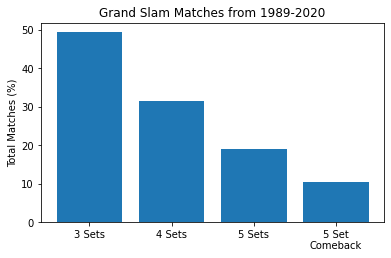

[49.42307692 31.43589744 19.14102564 10.37820513]


In [46]:
#Plot distribution of sets for entire tournament:

plt.figure(figsize=(7.2/1.3, 4.8/1.3))
xticks=['3 Sets', '4 Sets', '5 Sets', '5 Set\nComeback', 'Higher Rated\n5 Set\nComeback']
sets_dist=df['# of Sets'].value_counts()[0:3].values
comeback_5sets=len(df[df['5-set Comeback']!=0])
sets_comeback_dist=np.append(sets_dist,comeback_5sets)/sum(sets_dist)*100
plt.bar(np.arange(4),height=sets_comeback_dist)
plt.xticks(np.arange(4),labels=xticks[0:4])
plt.ylabel('Total Matches (%)')
plt.title('Grand Slam Matches from 1989-2020')
plt.tight_layout()
# plt.savefig('Figures/figure 2 Distribution of all matches.png', dpi=2000)
plt.show()
print(sets_comeback_dist)

## 3) Evaluate fairness of best of 1, 3, and 5 sets
A format is fairer if the better player is more likely to win. Here, I compare how often differently rated players win in best of 5, best of 3 and best of 1 set matches.

a) Plot a scatter plot of the percentage of wins for the lower rated player (percentage of upsets) as a function of the difference in rating between players for best of 5, best of 3, and best of 1 set matches. 

b) Plot bar graphs to compare the number of 5 set comebacks for higher and lower rated players. The difference in percent of lower rated 5 set comebacks to higher rated 5 set comebacks gives a lower bound for the fairness increase of a 5 set match. Likewise for 3 set comebacks.

c) Plot the upper and lower bounds for the increase in fairness of each change in format.

### a) Plot lower rated player win % vs rating differential with 95% confidence intervals (binomial) on data points and linear fits using weights. Plot for 1, 3, and 5 sets.

Define functions for creating the plots:

In [47]:
def error_bars(f):
    '''Gets lower and upper error bars from confidence intervals (confidence intervals are binomial, so are asymmetric)'''
    f['yerr-']=abs(f['CI'][0]-f['Percent Upsets']/100)*100
    f['yerr+']=abs(f['CI'][1]-f['Percent Upsets']/100)*100
    return f

def f(x,m,b): 
    '''Defines the fitting function to be a linear curve'''
    return m*x+b

def create_df(name,df_rated_diff):
    '''
    Creates a new data frame to see how often the lower rated player wins as a function 
    of the rating difference between players
    
    Parameters:
    name (string): String with the column name in the data frame representing
    whether the higher or lower rated player won (e.g. 'Rated Winner 1')
    df_rated_diff (dataframe): Data frame with all the same columns as df, but without 
    any unrated players in the matches.
    
    Output:
    df_diff (dataframe). This is a data frame with the following columns:
    - Rating Differential: Rating difference between players in any match.
    - Rating Differential Totals: Total number of matches between players of that rating
    differential.
    - Rating Differential Lower Rated Wins: Total number of matches where the lower rated
    player won in a match with that rating differential
    - Percent Upsets: Percent of matches where the lower rated player won
    - CI: Confidence interval on the percent upsets.
    - yerr-: Lower error bar on the percent upsets.
    - yerr+: Upper error bar on the percent upsets.
    
    '''
    diff_totals=df_rated_diff['Rating Differential'].value_counts() #Total number of data points (used in calculating CI) organized by the differential in rating
    low_diff_win5=df_rated_diff[df_rated_diff[name]==-1]['Rating Differential'].value_counts() # get all the wins for lower rated player organized by the differential in rating
    df_diff = pd.concat([diff_totals,low_diff_win5], axis=1, sort=False) #put total matches and wins (two above variables) into a df
    df_diff.fillna(0,inplace=True) #Fill win counts which are na with zeros.
    df_diff.columns=['Rating Differential Totals','Rating Differential Lower Rated Wins'] #Name columns
    #Percent of matches where the lower rated player wins (i.e. upsets):
    df_diff['Percent Upsets']=df_diff.apply(lambda x: x['Rating Differential Lower Rated Wins']/x['Rating Differential Totals']*100,axis=1)
    #The rating differential is equal to the index:
    df_diff['Rating Differential']=df_diff.index
    df_diff['CI']=df_diff.apply(lambda x: proportion_confint(count=x['Rating Differential Lower Rated Wins'], nobs=x['Rating Differential Totals'], method='binom_test', alpha=0.05),axis=1)
    df_diff=df_diff.apply(error_bars,axis=1)
    return df_diff

def create_plot(color,alpha,legend,df_diff):
    '''
    Plots the percent upsets vs the rating differential of players with uncertainty bars
    and a linear fit. Also prints the weighted average of the y values in the plot.
    
    Parameters:
    color (string): String giving the color to use for the data in the plot.
    alpha (ing): Integer giving the transparency of the data in the plot.
    legend (string): String giving the name to put in the legend of the data.
    df_diff (data frame): Data frame with how often the lower rated player wins as a 
    function of the rating difference between players
    
    Outputs:
    Plot with the percent upsets vs the rating differential of players with uncertainty bars
    and a linear fit.
    Prints the weighted average of the y values in the plot.
    
    '''
    plt.errorbar(x=df_diff['Rating Differential'],y=df_diff['Percent Upsets'],yerr=df_diff[['yerr-','yerr+']].T.values, linestyle="None",capsize=5,fmt='o',markersize=3,color=color,alpha=alpha)
    x=df_diff['Rating Differential']
    y=df_diff['Percent Upsets']
    df_diff['Uncertainty']=df_diff.apply(lambda x: x['yerr+'],axis=1)# #Make uncertainty column. Use only + side because - are small in binomial.
    sigma=df_diff['Uncertainty']/2 #Function accepts CI of 67%, but our confidence interval covers 95%.
    p0=-1,50 #Initialize parameters
    popt,pcov=curve_fit(f,x,y,p0,sigma=sigma,absolute_sigma=True)
    yfit=f(x,*popt)
    plt.plot(x, yfit, linewidth=3,color=color, label=legend)
    print(f"Weighted average of percent of upsets for {legend}: {np.average(df_diff['Percent Upsets'],weights=df_diff['Rating Differential Totals'])}") #weighted mean of percent upsets.

def create_plots(names,colors,alphas,legends,df_rated_diff):
    '''
    Plots % upsets for best of 1, 3, and 5 set matches on one graph. Executes create_df
    and create_plot for each match format.
    '''
    for name, color, alpha, legend in zip_longest(names,colors,alphas,legends):
        df_diff=create_df(name,df_rated_diff)
        create_plot(color,alpha,legend,df_diff)

Create the plot by executing above functions.

Weighted average of percent of upsets for Best of 1 set: 36.21372031662269
Weighted average of percent of upsets for Best of 3 sets: 30.936675461741427
Weighted average of percent of upsets for Best of 5 sets: 29.61741424802111


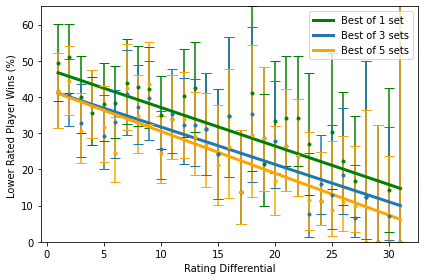

In [48]:
#Initial parameters:
names=['Rated Winner 1','Rated Winner 3','Rated Winner'] #column names
colors=['green','#1f77b4','orange'] #Color of plots
alphas=[1,1,1] #Plot transparency
legends=['Best of 1 set','Best of 3 sets','Best of 5 sets'] #Plot legend

#Make a dataframe with only rated players and their differential:
df_rated_diff=df[(df['Rating Differential']!=0) & (df['Rating Differential']<40)]

#Create figure:
fig=plt.figure(figsize=(6,4))
create_plots(names,colors,alphas,legends,df_rated_diff)
plt.ylim([0,65])
plt.legend(loc='upper right')
plt.ylabel('Lower Rated Player Wins (%) ')
plt.xlabel('Rating Differential')
plt.tight_layout()
# plt.savefig('Figures/Upsets vs Rating Differential.png',dpi=1000)

### b) Plot bar graphs to compare the number of 5 set comebacks for higher and lower rated players. 
Different from a) in that it includes matches between rated and unrated players as well. 

The difference in percent of lower rated 5 set comebacks to higher rated 5 set comebacks gives a lower bound for the fairness increase of a 5 set match. Likewise for 3 set comebacks.

Make a new data frame without matches between unrated players:

In [49]:
df_rated=df[(df['Player 1 Rating']!=100) | (df['Player 2 Rating']!=100)]

#Get rid of matches which ended early due to injuries for 5 and 3 set matches:
df_rated=df_rated[df_rated['# of Sets']>2] #for 5 set matches
df_rated3=df_rated[df_rated['# of Sets']>1] #for 3 set matches

#Get percentage of 5 and 3 set comebacks to use in figures below:
comeback5_total=sum(df_rated['Rated 5-set Comeback'].value_counts(normalize=True)[1:3])
comeback3_total=sum(df_rated3['Rated 3-set Comeback'].value_counts(normalize=True)[1:3])

#Get percentage of 5 and 3 set comebacks for higher and lower rated players:
df5set_rated=df[df['Rated 5-set Comeback']!=0]
df3set_rated=df[df['Rated 3-set Comeback']!=0]

Plot the distribution of games won depending on if they are higher or lower rated (all 4 figures plotted above in one figure):

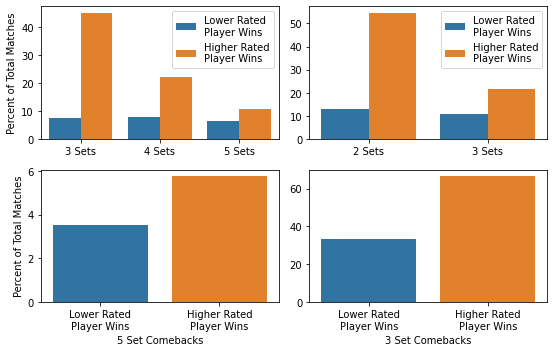

In [50]:
fig, ax =  plt.subplots(2,2,sharey=False,figsize=(7.8,5))

#Upper left figure: distribution of games won for 5-setters depending on if they are higher or lower rated:
ax[0,0] = sns.barplot(x='# of Sets',y='# of Sets',data=df_rated, estimator=lambda x: len(x) / len(df_rated) * 100,hue='Rated Winner',ax=ax[0,0])
ax[0,0].set(ylabel="Percent of Total Matches")
ax[0,0].get_legend_handles_labels()[0]
ax[0,0].legend((ax[0,0].get_legend_handles_labels()[0]),('Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'))
ax[0,0].set_xticklabels(['3 Sets','4 Sets','5 Sets'])
ax[0,0].set_xlabel('')

##### Upper right figure: distribution of games won for 3-setters depending on if they are higher or lower rated:
ax[0,1] = sns.barplot(x='# of Sets 3',y='# of Sets 3',data=df_rated3, estimator=lambda x: len(x) / len(df_rated3) * 100,hue='Rated Winner 3',ax=ax[0,1])
ax[0,1].set(ylabel="")
ax[0,1].get_legend_handles_labels()[0]
ax[0,1].legend((ax[0,1].get_legend_handles_labels()[0]),('Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'))
ax[0,1].set_xticklabels(['2 Sets','3 Sets'])
ax[0,1].set_xlabel('')

#### Lower left figure: 5 set comebacks for higher and lower seeds
ax[1,0] = sns.barplot(x='Rated 5-set Comeback',y='Rated 5-set Comeback',data=df5set_rated, estimator=lambda x: len(x) / len(df5set_rated)*comeback5_total*100 ,ax=ax[1,0])
ax[1,0].set(ylabel="Percent of Total Matches")
ax[1,0].set(xlabel="5 Set Comebacks")
ax[1,0].set(xticklabels=['Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'])

##### Lower right figure: 3 set comebacks for higher and lower seeds:
ax[1,1] = sns.barplot(x='Rated 3-set Comeback',y='Rated 3-set Comeback',data=df3set_rated, estimator=lambda x: len(x) / len(df3set_rated) *100 ,ax=ax[1,1])
ax[1,1].set(ylabel="")
ax[1,1].set(xlabel="3 Set Comebacks")
ax[1,1].set(xticklabels=['Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'])

# Save figures:
plt.tight_layout()
# fig.savefig('Figures/figure 4 Rated Players Breakdown best of 3 and best of 5 and comebacks.png',dpi=1500)
# fig.savefig('Figures/figure 4 Rated Players Breakdown best of 3 and best of 5 and comebacks.svg')

## c) Plot upper and lower fairness bounds
Uses increase in fairness from b) (and some simple math not shown here) to get the upper and lower bounds.

Plot upper and lower fairness bounds:


Theoretical estimate for the increase in fairness by set: 
[69.7455      8.33305605  5.27511255  3.71036511  2.74025427  2.08161082
  1.61056085  1.26228848  0.9988403   0.79623019  0.63845223]


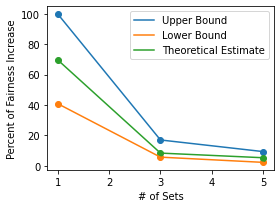

In [51]:
# x-axis: Number of sets:
x=np.arange(3)*2+1

#Upper and lower bounds of increase in fairness:
yhigh=np.array([100,16.976,9.3078]) 
ylow=np.array([40.9,5.6666,2.228])

#Theoretical increase in fairness if p=0.697 of winning any given set, using binomial.
#Note: this is only an estimate, since each match would have its own p.
p=[(1-binom.cdf(i,i*2+1,0.697455)) for  i in range(11)]
p_inc=np.array([(1-binom.cdf(i,i*2+1,0.697455))-(1-binom.cdf(i-1,(i-1)*2+1,0.697455)) for  i in range(11)])*100
print(f'\nTheoretical estimate for the increase in fairness by set: \n{p_inc}')

#Plot upper, lower bounds, and theoretical increase in fairness:
plt.figure(figsize=(4,3))
plt.scatter(x, yhigh)
plt.plot(x, yhigh)
plt.scatter(x,ylow)
plt.plot(x,ylow)
plt.scatter(x,p_inc[0:3])
plt.plot(x,p_inc[0:3])

plt.xlabel('# of Sets')
plt.ylabel('Percent of Fairness Increase')
plt.legend(['Upper Bound','Lower Bound','Theoretical Estimate'])
plt.tight_layout()
# plt.savefig('Figures/Figure 4 Upper and Lower Bounds.png', dpi=1000)

## 4) Are players more likely to be injured in best of 5 set matches?
Compare the regular distribution of matches to the distribution of matches before a player is injured

Make a data frame only with matches with injuries (excluding the first round)

In [52]:
df_inj=df[(df['Player 1 Score'].apply(len)!=df['Player 2 Score'].apply(len)) & (df['Round']!=1)]#All injured playes

Get the number of times a player gets injured when the previous match had length of 0,1,2,3,4 or 5 sets long:

In [53]:
sets_before_inj=[]
for index, row in df_inj.iterrows():
    slam=row['Grand Slam'] #Get the grand slam in which the player was injured
    round_before=row['Round']-1 #Get round before the one in which the player was injured
    #Get the player who was injured:
    if row['Player 1 Score']<row['Player 2 Score']:
        player=row['Player 1'].split(' ')[-1] #player 1 was injured
    else:
        player=row['Player 2'].split(' ')[-1] #player 2 was injured
    #Get the number of sets in the match before the match where the player was injured: 
    sets_before_inj_1=df[(df['Grand Slam']==slam) & (df['Round']==round_before) & ((df['Player 1'].apply(lambda x: x.split(' ')[-1])==player) | (df['Player 2'].apply(lambda x: x.split(' ')[-1])==player))]['# of Sets']
    sets_before_inj.append(sets_before_inj_1.array[0])

np.array(sets_before_inj)
counts=np.bincount(sets_before_inj)
print(f'Number of sets played in round before injury: frequency \n{[i for i in range(6)]}: {counts}')

Number of sets played in round before injury: frequency 
[0, 1, 2, 3, 4, 5]: [ 0  0  1 88 52 52]


Plot distribution of sets for regular matches and in the matches before an injury:

[49.42307692 31.43589744 19.14102564]


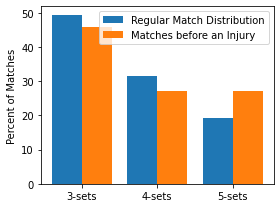

In [54]:
fig=plt.figure(figsize=(4,3))
width=.4

#Regular distribution:
sets_dist=df['# of Sets'].value_counts()[0:3].values
plt.bar(np.arange(3)-width,width=width,height=sets_dist/sum(sets_dist)*100)
print(sets_dist/sum(sets_dist)*100)

#Distribution of sets before an injury
perc_counts=counts[3:]/sum(counts[3:])

#Plot distributions:
plt.bar(np.arange(3),width=width,height=perc_counts*100)
plt.xticks(np.arange(3)-width/2,['3-sets','4-sets','5-sets'])
plt.ylabel('Percent of Matches')
plt.legend(['Regular Match Distribution','Matches before an Injury'])
plt.tight_layout()
# plt.savefig('Figures/Figure 4 Length of Match before Injury.png',dpi=1000)

## 5) Additional analysis: How often do different seeds win grand slams?

Make a plot of the percentage of times a seed wins as a function of their rating:

(0.0, 34.0)

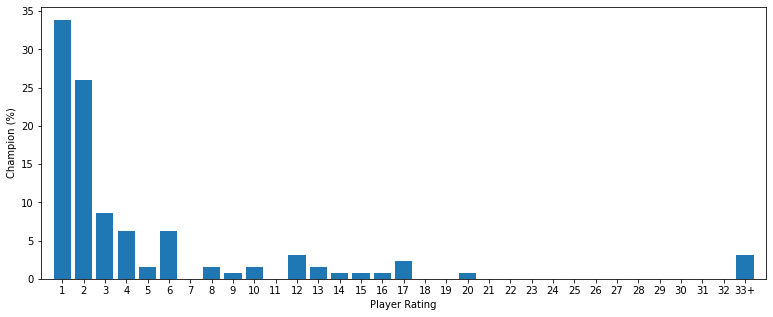

In [55]:
# Make a data frame with only the final match from each slam:
df_finals=df[df['Round']==7]

rating_slam_wins=df_finals['Winner Rating'].value_counts()
rating_slam_wins[2]+=2 #2 grand slams not in Wikipedia project
rating_slam_wins = rating_slam_wins.rename(index={100: 33}) 

# Plot percentage of slam wins by rating:
plt.figure(figsize=(13,5))
plt.bar(x=rating_slam_wins.index,height=rating_slam_wins/sum(rating_slam_wins)*100)
plt.xlabel('Player Rating')
plt.ylabel('Champion (%)')
l=list(range(1,33))
l.append('33+')
plt.xticks(np.arange(1,34),l)
plt.xlim((0,34))
# print(rating_slam_wins[1])
# print(rating_slam_wins[1]/sum(rating_slam_wins)*100)

Save the dataframe as a .csv file for future use:

In [56]:
df.to_csv('Tennis_DataFrame.csv')